In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
import sqlite3
from astropy.time import Time
from joblib import Parallel, delayed
from tqdm import tqdm
import time 
%matplotlib inline

In [6]:
def get_time_range(baseline):
    """
    Query the baseline database to get the observation time range.

    Parameters:
    baseline (str): Path to the baseline database file.

    Returns:
    tuple: Start and end MJD of observations.
    """
    conn = sqlite3.connect(baseline)
    cursor = conn.cursor()
    
    query = "SELECT MIN(observationStartMJD), MAX(observationStartMJD) FROM observations"
    cursor.execute(query)
    result = cursor.fetchone()
    
    conn.close()
    
    return result

def calculate_annual_qso_numbers(baseline, nside, maps, outdir, ourdir_db, start_mjd):
    """
    Calculate annual QSO numbers for different filters.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.
    start_mjd (float): Start MJD of observations.

    Returns:
    dict: Dictionary of metric bundles for each filter and year.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    annual_bundles = {year: {} for year in range(1, 11)}  # Dictionary to hold results for each year
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)

    for year in range(1, 11):
        #print(f"Processing year {year}...")
        for f in ('u', 'g', 'r', 'i', 'z', 'y'):
            metric = maf.QSONumberCountsMetric(f, zmax=6.7)
            year_start_mjd = start_mjd
            year_end_mjd = start_mjd + year * 365.25
            sql = f'filter = "{f}" and observationStartMJD >= {year_start_mjd} and observationStartMJD < {year_end_mjd}'
            bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band year {year}')
            annual_bundles[year][f] = bundle

        results_db = maf.db.ResultsDb(out_dir=os.path.join(ourdir_db, run_name))
        bundle_group = maf.MetricBundleGroup(annual_bundles[year], baseline_file, out_dir=outdir, results_db=results_db)
        bundle_group.run_all()

    return annual_bundles

def find_db_files(directory):
    db_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".db"):
                db_files.append(os.path.join(root, file))
    return db_files


In [ ]:
def main(baseline):
    # Configure paths
    nside = 64
    outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Rolling_result/npz'
    ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Rolling_result/db'

    # Generate survey areas
    survey_areas = SkyAreaGenerator(nside=nside)
    map_footprints, map_labels = survey_areas.return_maps()

    # Select HEALPix IDs for specific regions
    # Possible labels: ['', 'LMC_SMC', 'bulge', 'dusty_plane', 'lowdust', 'nes', 'scp', 'virgo']
    maps = np.where(
        (map_labels == 'LMC_SMC') |
        (map_labels == 'bulge') |
        (map_labels == 'dusty_plane') |
        (map_labels == '') |
        (map_labels == 'lowdust') |
        (map_labels == 'nes') |
        (map_labels == 'scp') |
        (map_labels == 'virgo')
    )[0]

    # Initialize dictionary to store annual QSO numbers
    db_name = os.path.split(baseline)[-1].replace('.db', '')
    directory_path = os.path.join(ourdir_db, db_name)
    
    start_mjd, end_mjd = get_time_range(baseline)
    start_date = Time(start_mjd, format='mjd').to_value('iso', subfmt='date')
    end_date = Time(end_mjd, format='mjd').to_value('iso', subfmt='date')

    # Calculate the difference in years
    start_time = Time(start_mjd, format='mjd')
    end_time = Time(end_mjd, format='mjd')
    difference_in_years = (end_time - start_time).to('year')

    # Calculate annual QSO numbers and store in the dictionary
    annual_bundles = calculate_annual_qso_numbers(baseline, nside, maps, outdir, ourdir_db, start_mjd)
    return 0

sim_baseline = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput//Rolling_db/'
baselines    = find_db_files(sim_baseline)
for i in baselines:
    main(i)

/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
import re
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def find_npz_files(directory):
    """
    Find all .npz files in the given directory and its subdirectories.
    
    Parameters:
    directory (str): The directory to search for .npz files.
    
    Returns:
    list: A list of file paths to .npz files.
    """
    npz_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".npz"):
                npz_files.append(os.path.join(root, file))
    return npz_files

def calculate_total_qsos_band(bundle):
    """
    Calculate the total number of QSOs for a given metric bundle.
    
    Parameters:
    bundle (MetricBundle): The metric bundle to calculate QSOs from.
    
    Returns:
    float: The total number of QSOs.
    """
    summary = maf.SumMetric(col='metric')
    bundle.set_summary_metrics([summary])
    bundle.compute_summary_stats()
    total_qsos = bundle.summary_values[summary.name]
    return total_qsos

def save_result(outdir):
    """
    Process QSO number counts for different filter bands and save the results as CSV files.
    
    Parameters:
    outdir (str): The directory to save the CSV files to.
    
    Returns:
    int: Status code (0 for success).
    """
    MAFOutdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Rolling_result/npz'
    file_names = find_npz_files(MAFOutdir)
    
    # Extract baseline names from file names
    baseline = set()
    for file_name in file_names:
        match = re.match(r'.*/(.*?3_4_10yrs)', file_name)
        if match:
            baseline.add(match.group(1))
    baseline = list(baseline)
    # For each filter band, process the data and save as CSV
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        data = {}
        for db in baseline:
            db_data = []
            for year in range(1, 11):
                file_npz = os.path.join(MAFOutdir, f'{db}_QSONumberCountsMetric_{f}_band_year_{year}_HEAL.npz')
                bundle = MetricBundle.load(file_npz)
                total_qso = calculate_total_qsos_band(bundle)
                db_data.append(total_qso)
            data[db] = db_data
        
        # Create DataFrame and transpose it
        df = pd.DataFrame(data)
        df_transposed = df.T
        df_transposed.columns = [f'Year{i+1}' for i in range(df_transposed.shape[1])]
        df_transposed.insert(0, 'Baseline', df_transposed.index)
        
        # Save to CSV
        output_file = os.path.join(outdir, f'QSONumberCounts_{f}.csv')
        df_transposed.to_csv(output_file, index=False)
    
    return 0

outdir = './'
save_result(outdir)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

0

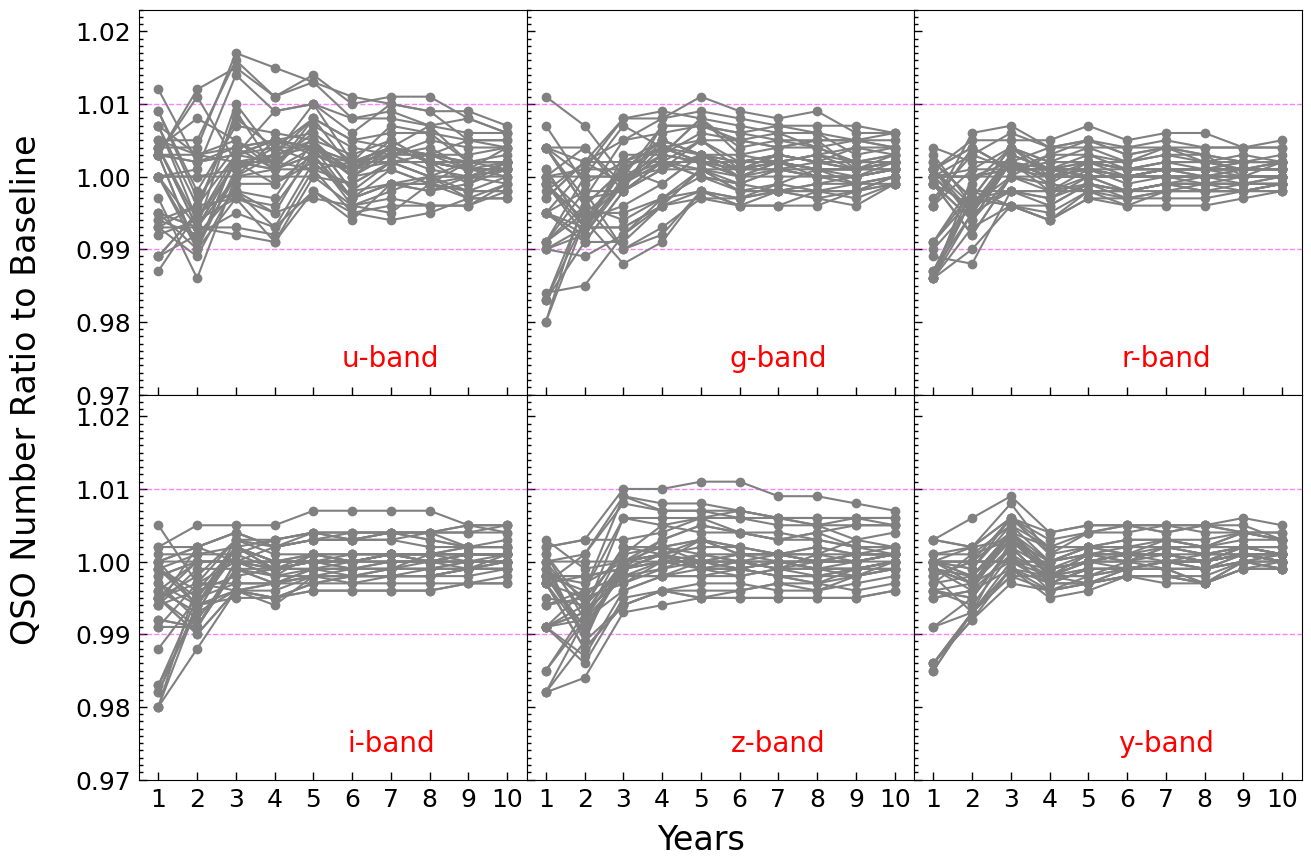

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

u_band = pd.read_csv('./QSONumberCounts_u.csv', index_col=0).sort_index()
g_band = pd.read_csv('./QSONumberCounts_g.csv', index_col=0).sort_index()
r_band = pd.read_csv('./QSONumberCounts_r.csv', index_col=0).sort_index()
i_band = pd.read_csv('./QSONumberCounts_i.csv', index_col=0).sort_index()
z_band = pd.read_csv('./QSONumberCounts_z.csv', index_col=0).sort_index()
y_band = pd.read_csv('./QSONumberCounts_y.csv', index_col=0).sort_index()
baseline = pd.read_csv('./baseline.csv')

bands = {
    'u': u_band,
    'g': g_band,
    'r': r_band,
    'i': i_band,
    'z': z_band,
    'y': y_band
}

filter_band=['u','g','r','i','z','y']
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex='col', sharey='row', 
                            gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
for i in range(6):
    axs[i].set_xlim(0.5,10.5)
    axs[i].set_ylim(0.97,1.023)
    ymajorLocator = MultipleLocator(0.01)
    yminorLocator = MultipleLocator(0.001)
    xmajorLocator = MultipleLocator(1)
    axs[i].yaxis.set_major_locator(ymajorLocator)
    axs[i].yaxis.set_minor_locator(yminorLocator)
    axs[i].xaxis.set_major_locator(xmajorLocator)
    axs[i].tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[i].tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    axs[i].text(7, 0.975, filter_band[i]+'-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
    axs[i].axhline(0.99,color='magenta',linewidth=1,linestyle='--',alpha=0.5)
    axs[i].axhline(1.01,color='magenta',linewidth=1,linestyle='--',alpha=0.5)

colors = cc.glasbey[:40]

years = np.arange(1,11,1)

for ax, (band_name, df) in zip(axs, bands.items()):
    i = 0
    for index, row in df.iterrows():
        row_array = np.array(row)
        ax.plot(years, np.around(row_array/baseline[band_name],decimals=3), label=index, color='grey', marker='o')
        i=i+1

handles, labels = axs[0].get_legend_handles_labels()
fig.text(0.5, 0.05, 'Years', ha='center', va='center', fontsize=24)
fig.text(0.05, 0.5, 'QSO Number Ratio to Baseline', ha='center', va='center', rotation='vertical', fontsize=24)
plt.show()
